In [20]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read the data
path = "../Datasets/"
train = pd.read_csv(path + '/Historical-transaction-data.csv')
storeInfo = pd.read_csv(path + '/Store-info.csv')
test = pd.read_csv(path + '/Testing-data.csv')

# merge the data
train = train.merge(storeInfo, on='shop_id', how='left')

storeInfo.drop("shop_profile", axis=1, inplace=True)
test = test.merge(storeInfo, on='shop_id', how='left')

# explore the database
# print first few rows of the data frame
print(train.head())

# print summary statistics of the numerical columns
print(train.describe())

# print information about the data frame
print(train.info())


        item_description          transaction_date  invoice_id customer_id  \
0     ORANGE BARLEY 1.5L  2021-12-11T00:00:00.000Z       147.0        BGXA   
1       GINGER BEER 1.5L  2021-10-17T00:00:00.000Z       371.0        IA25   
2        TONIC PET 500ML  2021-12-13T00:00:00.000Z       484.0        VN7V   
3          CREAM SODA 1L  2021-12-13T00:00:00.000Z       484.0        VN7V   
4  STRAWBERRY MILK 180ML  2021-10-23T00:00:00.000Z      1310.0        7S00   

   shop_id  item_price  quantity_sold  shop_area_sq_ft shop_profile  
0  SHOP008         220              2              678     Moderate  
1  SHOP112         220              2              668     Moderate  
2  SHOP008         160              2              678     Moderate  
3  SHOP008         150              2              678     Moderate  
4  SHOP112         210              5              668     Moderate  
         invoice_id     item_price  quantity_sold  shop_area_sq_ft
count  4.676540e+05  473974.000000  473974.0

item_description    35928
transaction_date        0
invoice_id           6320
customer_id             0
shop_id                 0
item_price              0
quantity_sold           0
shop_area_sq_ft         0
shop_profile        86633
dtype: int64


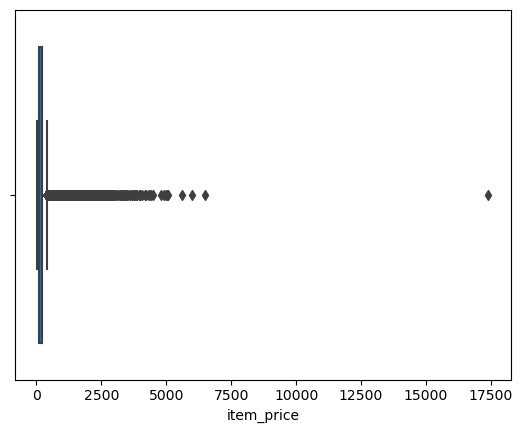

In [21]:
# clean the data
# check for missing values
print(train.isnull().sum())

# replace missing values with mean or median values
train['invoice_id'].fillna(train['invoice_id'].median(), inplace=True)

# check for outliers
sns.boxplot(x=train['item_price'])
plt.show()

# remove outliers using interquartile range (IQR)
Q1 = train['item_price'].quantile(0.25)
Q3 = train['item_price'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['item_price'] >= Q1 - 1.5*IQR) & (train['item_price'] <= Q3 + 1.5*IQR)]


In [22]:
# preprocess the data

# convert categorical variables into numerical variables
train['item_description'] = train['item_description'].astype('category')
train['customer_id'] = train['customer_id'].astype('category')
train['shop_id'] = train['shop_id'].astype('category')
train['shop_profile'] = train['shop_profile'].astype('category')

# convert transaction_date into datetime format
train['transaction_date'] = pd.to_datetime(train['transaction_date'])

# create new features as year, month, day, and weekday
train['year'] = train['transaction_date'].dt.year
train['month'] = train['transaction_date'].dt.month
train['day'] = train['transaction_date'].dt.day
train['weekday'] = train['transaction_date'].dt.weekday

# transform categorical variables into numerical variables
train['item_description'] = train['item_description'].cat.codes
train['customer_id'] = train['customer_id'].cat.codes
train['shop_id'] = train['shop_id'].cat.codes
train['shop_profile'] = train['shop_profile'].cat.codes


In [24]:
# drop transaction_date column
train.drop("transaction_date", axis=1, inplace=True)

## Feature Engineering and Selection
We can use feature engineering and selection techniques to identify the most relevant features for our model. Some common techniques are:

1. Correlation matrix: Identify the features with the highest correlation with the target variable.
2. Recursive Feature Elimination (RFE): Use a machine learning model to recursively eliminate the least important features.
3. Principal Component Analysis (PCA): Reduce the dimensionality of the data by transforming the features into a lower-dimensional space.

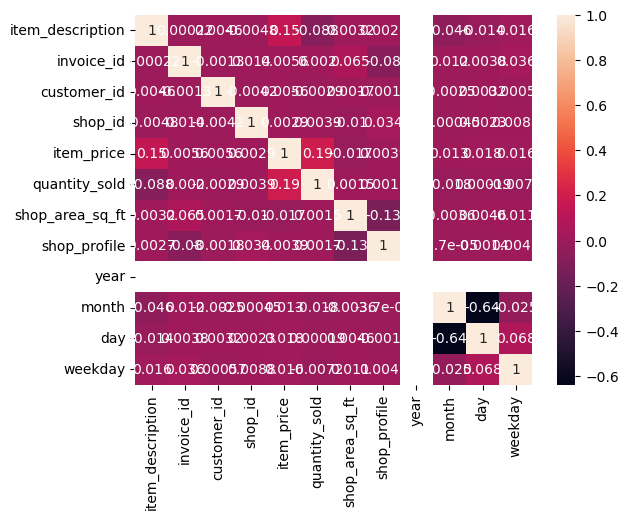

In [32]:
# correlation matrix
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

X = train.drop('shop_profile', axis=1)
y = train['shop_profile']

# label encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [35]:
model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]

# principal component analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

## Model Selection and Training
We can use various machine learning models to predict the target variable (total revenue) based on the selected features. Some common models are:

1. Linear Regression
2. Decision Trees
3. Random Forests
4. Gradient Boosting

In [36]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

# decision trees
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# random forests
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)


GradientBoostingRegressor()

## Evaluate and Optimize the Model
Once we have trained the models, we need to evaluate their performance and optimize them if necessary. We can use various metrics to evaluate the model, such as:

1. Mean Absolute Error (MAE)
2. Mean Squared Error (MSE)
3. Root Mean Squared Error (RMSE)
4. R-Squared (R2)
5. F1 Score (F1)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score

# evaluate linear regression
lr_pred = lr.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
print(f'Linear Regression: MAE={lr_mae:.2f}, MSE={lr_mse:.2f}, RMSE={lr_rmse:.2f}, R2={lr_r2:.2f} F1={lr_f1:.2f}')

# evaluate decision trees
dt_pred = dt.predict(X_test)
dt_mae = mean_absolute_error(y_test, dt_pred)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

print(f'Decision Trees: MAE={dt_mae:.2f}, MSE={dt_mse:.2f}, RMSE={dt_rmse:.2f}, R2={dt_r2:.2f} F1={dt_f1:.2f}')

# evaluate random forests
rf_pred = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

print(f'Random Forests: MAE={rf_mae:.2f}, MSE={rf_mse:.2f}, RMSE={rf_rmse:.2f}, R2={rf_r2:.2f} F1={rf_f1:.2f}')

# evaluate gradient boosting
gb_pred = gb.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_mse = mean_squared_error(y_test, gb_pred)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)

print(f'Gradient Boosting: MAE={gb_mae:.2f}, MSE={gb_mse:.2f}, RMSE={gb_rmse:.2f}, R2={gb_r2:.2f} F1={gb_f1:.2f}')

# optimize hyperparameters using grid search
# grid search for random forests
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(rf, params, cv=5)
rf_grid.fit(X_train, y_train)

print(rf_grid.best_params_)


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets